# Relationship Between Stock Prices, Interest Rates, and Inflation in the US Market

This Jupyter notebook analyzes the relationship between the S&P 500 stock prices, US real interest rates, and US inflation rates from 1982 to 2023.

**Key steps in the analysis:**
- Load and merge S&P 500 price data, inflation data, and real interest rate data.
- Compute Pearson correlations to measure linear relationships.
- Perform linear regression of S&P 500 on interest rates to quantify how the stock price changes with interest rates.
- Conduct lag analysis using cross-correlation to see if changes in interest rates lead changes in stock prices after some months.
- Visualize the results, including time series plots, scatter plots, and a cross-correlation plot.

All results are printed and visualized within this notebook.

In [33]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

## Data Loading and Preprocessing
In this section, we:
1. Load S&P 500 data, which includes dates and monthly prices.
2. Load inflation data, which is provided in a wide format (Year as rows, months as columns) and melt it to a long format with a proper Date column.
3. Load real interest rate data, which includes monthly dates and corresponding interest rates.
4. Merge all three datasets on the monthly date.
5. Clean and prepare the resulting DataFrame for analysis.

In [34]:
# Load S&P 500 data
# The CSV file contains dates and prices, with commas in the price.
# We remove commas and convert to float. Dates are parsed to datetime.
sp500 = pd.read_csv('S&P_500_1982-2023.csv')
sp500['Price'] = sp500['Price'].str.replace(',', '').astype(float)  # Clean price format
sp500['Date'] = pd.to_datetime(sp500['Date'], format='%d/%m/%Y')  # Convert date strings to datetime

# Load Inflation data (Excel):
# This dataset has a format: Year | Jan | Feb | ... | Dec.
# We'll melt it so we have a single column for Month and a single column for Inflation_Rate.
inflation = pd.read_excel('US_Monthly_Inflation_Rate_1982-2023.xlsx')
inflation_melted = inflation.melt(id_vars=['Year'], var_name='Month', value_name='Inflation_Rate')

# Create a mapping from month abbreviations to month numbers.
month_map = {
    'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04',
    'May': '05', 'Jun': '06', 'Jul': '07', 'Aug': '08',
    'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'
}

# Use the year and mapped month number to create a proper Date column.
inflation_melted['Month_Num'] = inflation_melted['Month'].map(month_map)
inflation_melted['Date'] = pd.to_datetime(inflation_melted['Year'].astype(str) + '-' + inflation_melted['Month_Num'], format='%Y-%m')

# Drop the original Year, Month, and Month_Num columns since we have a proper Date now.
inflation_melted = inflation_melted.drop(['Year', 'Month', 'Month_Num'], axis=1)

# Load Interest Rate data:
# CSV with DATE and REAINTRATREARAT10Y columns.
interest = pd.read_csv('US_Monthly_Real_10Y_Interest_Rate_1982-2023.csv')
interest['Date'] = pd.to_datetime(interest['DATE'], format='%Y/%m/%d')  # Convert date column to datetime
interest = interest.rename(columns={'REAINTRATREARAT10Y': 'Interest_Rate'})
interest = interest.drop(['DATE'], axis=1)

# Merge all three datasets on Date.
# First merge S&P 500 with inflation, then merge the result with interest rates.
merged_data = pd.merge(sp500, inflation_melted, on='Date', how='inner')
merged_data = pd.merge(merged_data, interest, on='Date', how='inner')

# Drop any rows with missing values (if any exist).
merged_data = merged_data.dropna()

# Display the first few rows to ensure merging worked correctly.
merged_data.head()

,Date,Price,Change %,Inflation_Rate,Interest_Rate
0,1982-01-01,120.4,-1.79%,0.3,7.623742
1,1983-01-01,145.3,3.34%,0.2,5.543389
2,1984-01-01,163.4,-0.91%,0.7,6.215304
3,1985-01-01,179.6,7.42%,0.2,6.161901
4,1986-01-01,211.8,0.24%,0.4,4.547185


## Data Visualization
We first visualize the data over time:
- S&P 500 price over time
- Interest rates over time
- Inflation rates over time

These plots help us understand general trends and patterns before doing statistical analysis.

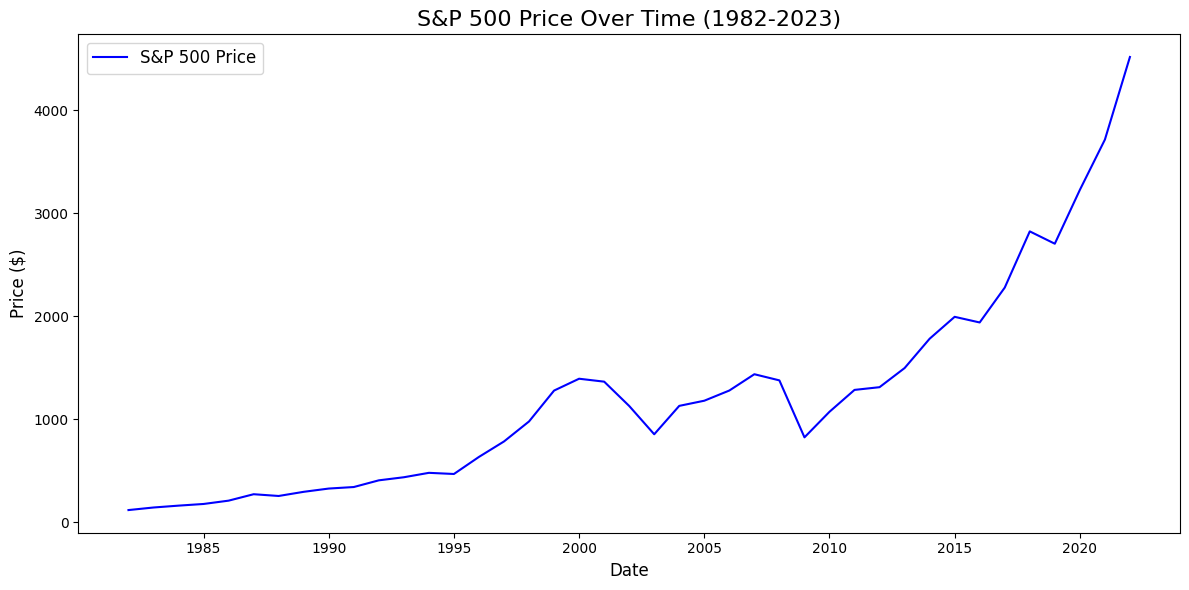

In [35]:
# Plot S&P 500 Price over time.
plt.figure(figsize=(12, 6))
plt.plot(merged_data['Date'], merged_data['Price'], label='S&P 500 Price', color='blue')
plt.title('S&P 500 Price Over Time (1982-2023)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

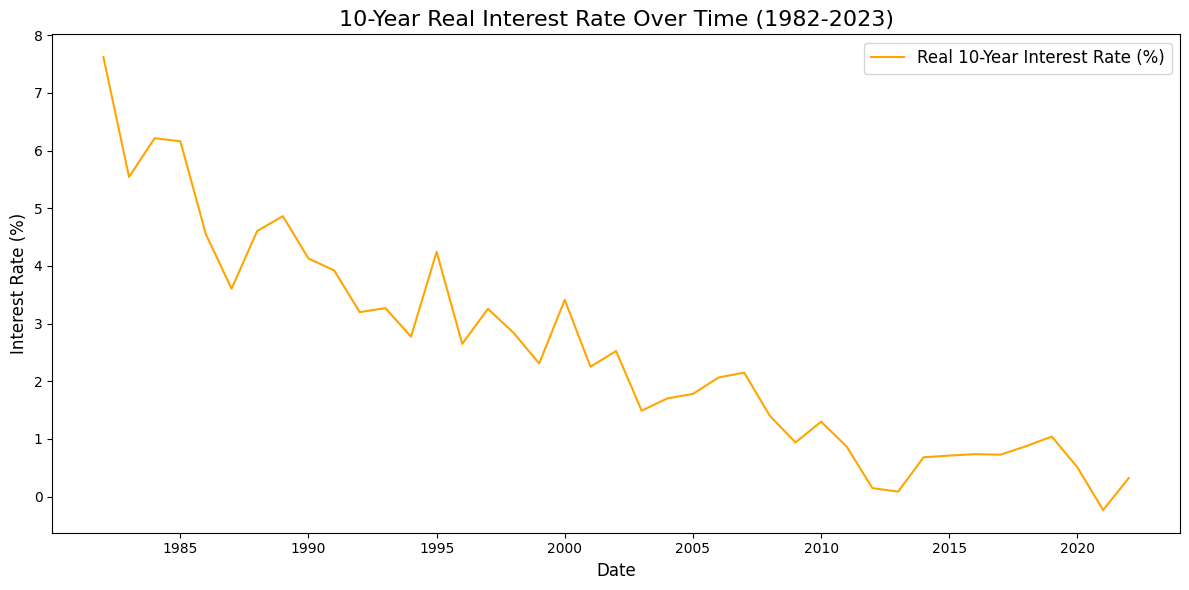

In [36]:
# Plot Real Interest Rate over time.
# Real interest rates can influence stock market valuations.
plt.figure(figsize=(12, 6))
plt.plot(merged_data['Date'], merged_data['Interest_Rate'], color='orange', label='Real 10-Year Interest Rate (%)')
plt.title('10-Year Real Interest Rate Over Time (1982-2023)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Interest Rate (%)', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

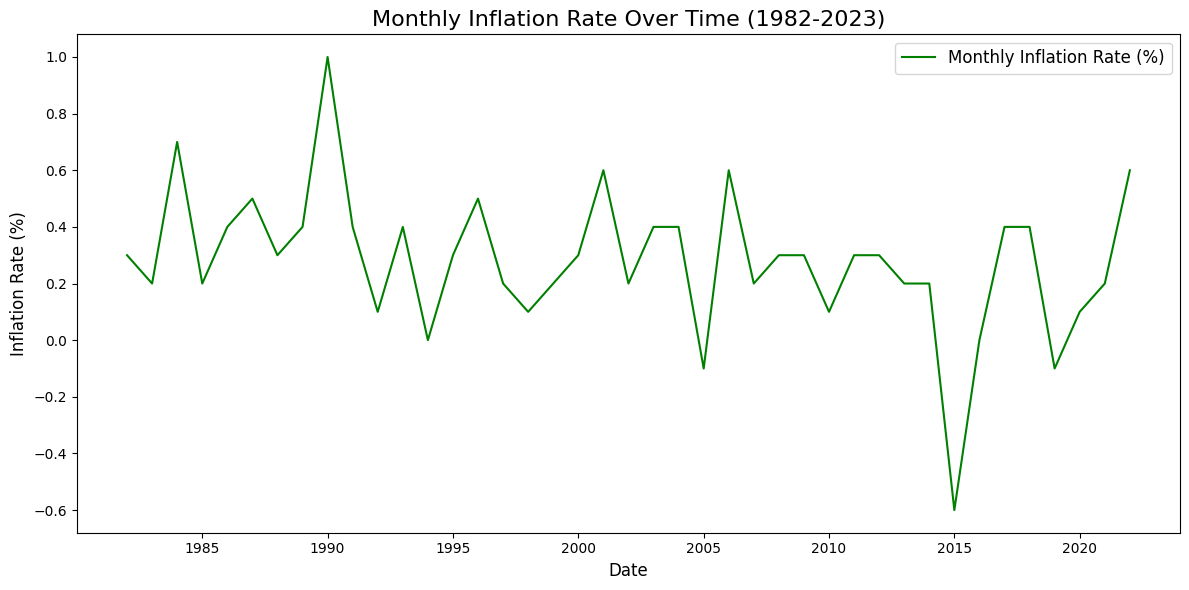

In [37]:
# Plot Inflation Rate over time.
# Understanding how inflation changed over the period gives context.
plt.figure(figsize=(12, 6))
plt.plot(merged_data['Date'], merged_data['Inflation_Rate'], color='green', label='Monthly Inflation Rate (%)')
plt.title('Monthly Inflation Rate Over Time (1982-2023)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Inflation Rate (%)', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## Statistical Analysis

In this section, we perform the following analyses:
1. **Pearson Correlation:** Measure the linear relationship between variables.
   - Interest Rate vs S&P 500 Price
   - Inflation Rate vs S&P 500 Price

2. **Linear Regression:**
   - Regress S&P 500 Price on Interest Rate to quantify how a change in interest rate affects stock prices.

3. **Lag Analysis (Cross-Correlation):**
   - Check correlation at different lags to see if interest rates lead stock price changes.


In [38]:
def pearson_confidence_interval(r, n, confidence=0.95):
    """
    Calculate the confidence interval for Pearson's correlation coefficient using Fisher's Z transformation.
    This gives us a range of plausible correlation values at a given confidence level.
    """
    # Fisher's Z transformation to transform r to a normally distributed variable
    z = 0.5 * np.log((1 + r) / (1 - r))
    se = 1 / np.sqrt(n - 3)  # Standard error of the transformed variable
    z_critical = stats.norm.ppf(1 - (1 - confidence) / 2)  # Z-score for the desired confidence interval
    z_lower = z - z_critical * se
    z_upper = z + z_critical * se
    # Convert back from Z to r
    r_lower = (np.exp(2*z_lower) - 1) / (np.exp(2*z_lower) + 1)
    r_upper = (np.exp(2*z_upper) - 1) / (np.exp(2*z_upper) + 1)
    return r_lower, r_upper

# Determine sample size
n = merged_data.shape[0]

# Pearson correlation between Interest Rate and S&P 500 Price
corr_interest_price, p_value_interest = stats.pearsonr(merged_data['Interest_Rate'], merged_data['Price'])
ci_interest = pearson_confidence_interval(corr_interest_price, n)
if p_value_interest < 0.0001:
    p_value_interest_display = "<0.0001"
else:
    p_value_interest_display = f"{p_value_interest:.4f}"

# Pearson correlation between Inflation Rate and S&P 500 Price
corr_inflation_price, p_value_inflation = stats.pearsonr(merged_data['Inflation_Rate'], merged_data['Price'])
ci_inflation = pearson_confidence_interval(corr_inflation_price, n)
if p_value_inflation < 0.0001:
    p_value_inflation_display = "<0.0001"
else:
    p_value_inflation_display = f"{p_value_inflation:.4f}"

### Correlation Results
Print out the correlation coefficients, confidence intervals, and p-values to assess the strength and significance of the relationships.

In [39]:
# Print correlation results
print("Correlation Results:")
print(f"Interest Rate vs S&P 500: r = {corr_interest_price:.4f}, 95% CI = [{ci_interest[0]:.4f}, {ci_interest[1]:.4f}], p = {p_value_interest_display}")
print(f"Inflation vs S&P 500: r = {corr_inflation_price:.4f}, 95% CI = [{ci_inflation[0]:.4f}, {ci_inflation[1]:.4f}], p = {p_value_inflation_display}")


Correlation Results:
Interest Rate vs S&P 500: r = -0.7487, 95% CI = [-0.8586, -0.5731], p = <0.0001
Inflation vs S&P 500: r = -0.1882, 95% CI = [-0.4687, 0.1268], p = 0.2386


### Linear Regression: S&P 500 vs Interest Rate
We will model S&P 500 Price = Intercept + Slope * Interest_Rate.
- If Slope < 0 and statistically significant, it suggests that increasing interest rates tend to lower S&P 500 prices.


In [40]:
# Perform linear regression: Price ~ Interest_Rate
slope, intercept, r_value, p_value_reg, std_err = stats.linregress(merged_data['Interest_Rate'], merged_data['Price'])
r_squared = r_value**2

# Calculate confidence interval for slope
df = n - 2  # Degrees of freedom for a simple linear regression
t_critical = stats.t.ppf(1 - 0.025, df)  # Two-tailed 95% CI
slope_ci = (slope - t_critical * std_err, slope + t_critical * std_err)

if p_value_reg < 0.0001:
    p_value_reg_disp = "<0.0001"
else:
    p_value_reg_disp = f"{p_value_reg:.4f}"

In [41]:
# Print regression results
print("\nLinear Regression (S&P 500 on Interest Rate):")
print(f"Intercept: {intercept:.2f}")
print(f"Slope: {slope:.2f} (95% CI: [{slope_ci[0]:.2f}, {slope_ci[1]:.2f}])")
print(f"R² = {r_squared:.4f}, p-value = {p_value_reg_disp}")

# Interpret the significance
if p_value_reg < 0.05:
    print("There is a significant linear relationship.")
    if slope < 0:
        print("As interest rates increase, S&P 500 prices decrease.")
else:
    print("No significant linear relationship detected.")


Linear Regression (S&P 500 on Interest Rate):
Intercept: 2232.67
Slope: -403.12 (95% CI: [-518.72, -287.53])
R² = 0.5606, p-value = <0.0001
There is a significant linear relationship.
As interest rates increase, S&P 500 prices decrease.


### Scatter Plot with Regression Line
Visualize the relationship between S&P 500 Price and Interest Rate along with the fitted regression line.

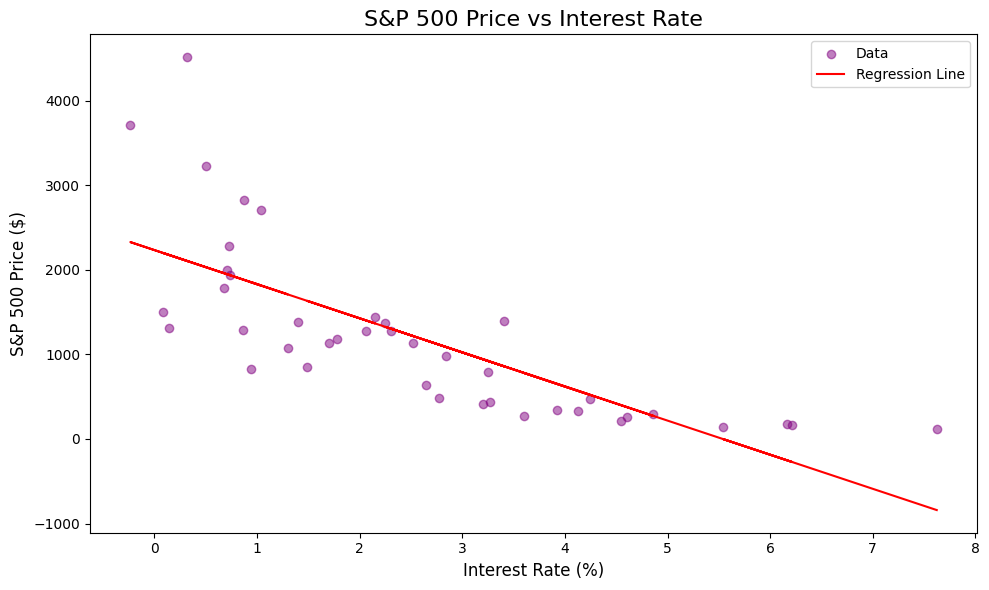

In [42]:
# Scatter plot with regression line
plt.figure(figsize=(10,6))
plt.scatter(merged_data['Interest_Rate'], merged_data['Price'], color='purple', alpha=0.5, label='Data')
reg_line = slope * merged_data['Interest_Rate'] + intercept
plt.plot(merged_data['Interest_Rate'], reg_line, color='red', label='Regression Line')
plt.title('S&P 500 Price vs Interest Rate', fontsize=16)
plt.xlabel('Interest Rate (%)', fontsize=12)
plt.ylabel('S&P 500 Price ($)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

### Lag Analysis (Cross-Correlation)
To determine if changes in interest rates lead changes in stock prices, we compare correlation at different lags.

For each lag `k` months, we shift the stock prices back by `k` months and see how well they correlate with current interest rates. If correlation is strongest at a positive lag, it suggests the interest rate changes come before stock price changes.

In [43]:
# Perform lag analysis
max_lag = 12  # Check lags up to 12 months
lags = range(0, max_lag+1)
correlations = []

for lag in lags:
    if lag == 0:
        # No lag: directly compare interest rate and price
        corr = merged_data['Interest_Rate'].corr(merged_data['Price'])
    else:
        # Shift S&P 500 Price backwards by 'lag' months
        # This means we are seeing if older interest rates align better with today's prices.
        shifted_price = merged_data['Price'].shift(lag)
        corr = merged_data['Interest_Rate'].corr(shifted_price)
    correlations.append(corr)

# Identify the lag with the maximum absolute correlation
max_corr = max(correlations, key=lambda x: abs(x) if pd.notnull(x) else -np.inf)
optimal_lag = lags[correlations.index(max_corr)]

In [44]:
# Print lag analysis results
print("\nLag Analysis:")
print(f"Maximum correlation = {max_corr:.4f} at lag = {optimal_lag} months.")

# If we find a lag > 0 with a stronger correlation than at lag 0, it suggests a leading relationship.
if optimal_lag > 0 and abs(max_corr) > abs(corr_interest_price):
    print("Evidence of a lagged effect: Changes in interest rates precede changes in stock prices.")
else:
    print("No strong evidence of a lag.")


Lag Analysis:
Maximum correlation = -0.8701 at lag = 5 months.
Evidence of a lagged effect: Changes in interest rates precede changes in stock prices.


### Cross-Correlation Plot
Visualize how the correlation changes with different lags.

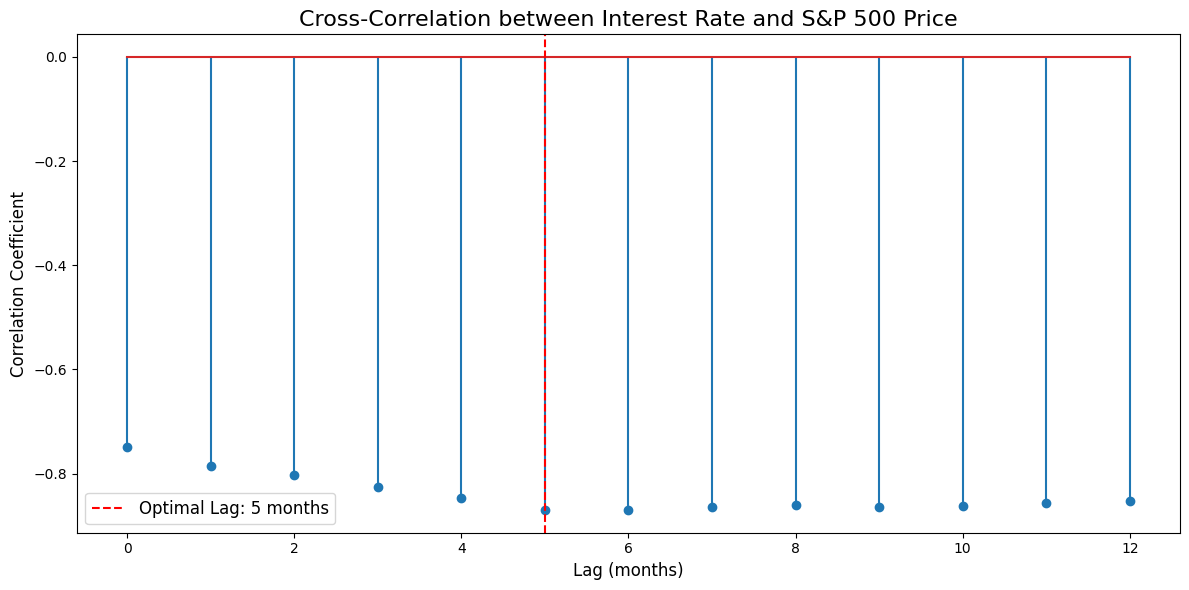

In [45]:
# Plot the cross-correlation results as a stem plot
plt.figure(figsize=(12,6))
plt.stem(lags, correlations)
plt.title('Cross-Correlation between Interest Rate and S&P 500 Price', fontsize=16)
plt.xlabel('Lag (months)', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.axvline(x=optimal_lag, color='red', linestyle='--', label=f'Optimal Lag: {optimal_lag} months')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

### Inflation and Stock Prices
Check if inflation rates have a significant relationship with stock prices.

In [46]:
# Print correlation results for Inflation and S&P 500
print("\nInflation and Stock Prices:")
print(f"Correlation: r = {corr_inflation_price:.4f}, p = {p_value_inflation_display}")
if p_value_inflation < 0.05:
    print("Significant relationship detected.")
else:
    print("No significant relationship detected.")


Inflation and Stock Prices:
Correlation: r = -0.1882, p = 0.2386
No significant relationship detected.


### Scatter Plot: S&P 500 vs Inflation Rate
Visualize if there's any discernible pattern between inflation and stock prices.

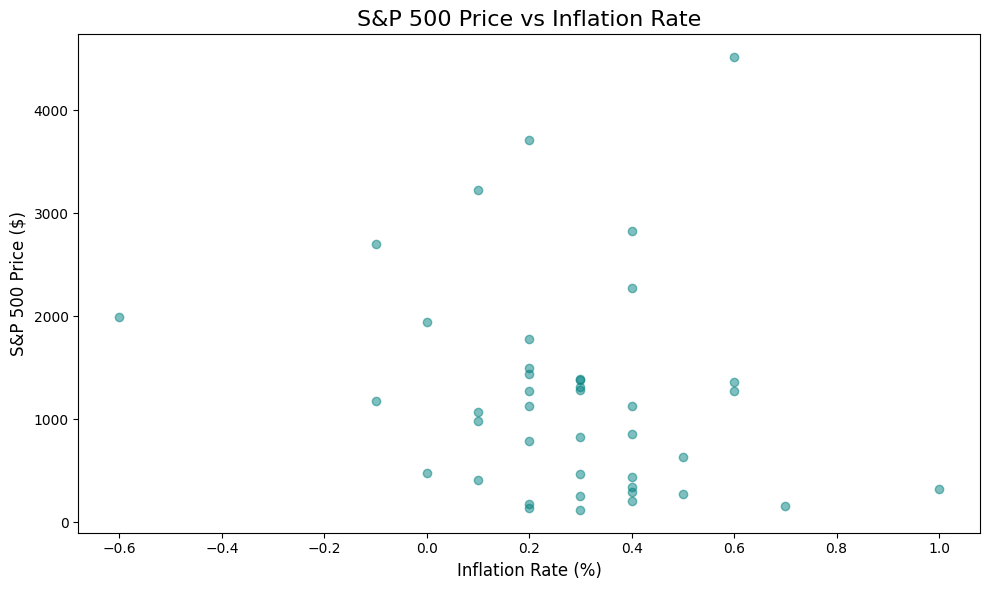

In [47]:
# Scatter plot of S&P 500 vs Inflation Rate
plt.figure(figsize=(10,6))
plt.scatter(merged_data['Inflation_Rate'], merged_data['Price'], color='teal', alpha=0.5)
plt.title('S&P 500 Price vs Inflation Rate', fontsize=16)
plt.xlabel('Inflation Rate (%)', fontsize=12)
plt.ylabel('S&P 500 Price ($)', fontsize=12)
plt.tight_layout()
plt.show()